In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as ss
import time
import pandas as pd
from abc import ABC, abstractmethod
i = complex(0, 1)

## Credit Value Adjustment  
### CVA IFRS 13
Credit Valuation Adjustment is a metric used to estimate potential losses from counterparty credit risk in financial transactions. It measures the difference between the risk-free value of a contract and its value considering the likelihood of the counterparty defaulting.  
CVA is crucial for evaluating the actual value and risk of contracts, particularly in Over-the-Counter derivatives trading. CVA is given by the following formula :  

$$\text{CVA}_{t_0} = \text{LGD}\cdot\mathbb{E}\left[ \text{DF}(t_0, \tau) \cdot \text{MtM}_\tau^\text{+} \cdot \mathbb{I}_{\{\tau < T\}} \right]$$

Where:

- $LGD$ is the loss given default of the counterparty.
- $\tau$ is a stopping time representing the time of counterparty default.
- $DF(t_0, \tau)$ represents the discounting factor from initial time $t_0$ to time of default $\tau$.
- $T$ is the maturity of the derivative.
- $MtM_\tau$ is the mark-to-market value of the derivative at the time of default.
  
  
When assuming the __absence of Wrong Way Risk__, the discretization of the above formula lead to the following result :  

$$
\text{CVA}_{t_0} = \text{LGD} \cdot \sum_{t_i} \text{DF}(t_0, t_i) \cdot \text{EE}(t_i) \cdot \max\{0, \text{PS}(t_{i-1}) - \text{PS}(t_i)\}
$$
$$\text{EE(t)} = \mathbb{E}\left[ \text{MtM}_t^+ \right]$$.

Where:
- $DF(t_0, t_i)$ is the discount factors at time $t_0$ for maturity $t_i$.

- $EE(t_i)$ is the expected exposure seen as of time $ t_0$ expected at time $ t_i $.
- $PS(t_i)$ is the survival probability at time $ t_i $.


### How to evaluate the value of a derivative : 

To compute CVA for any finacial instrument, there are basicaly 4 components to take into account : The __Discounting Factor__, the __Expected Exposure__, the __Survival Probabilities__ and the __Loss Given Default__.

#### 1. Estimation of the Expected Exposure.
- Diffusion of risk factors.
- Projection of the Mark to Market values
- Compute the positive exposures 
- Compute the CVA 


#### Define utility functions 

In [2]:
def plot_diffusion(t, data, title, y_label, x_label = "Time step"):
    
    plt.figure(figsize=(12, 6))
    #t = np.linspace(0, data.shape[1] - 1, data.shape[1])

    plt.plot(t, data[:100].T, alpha=0.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    plt.tight_layout()
    plt.show()

def plot_results(t, MtM_values, EE_values, MtM_title, EE_title, y_label1 = "Option value", y_label2 = "Expected Exposure"):
    
    plt.figure(figsize=(12, 6))
    #t = np.linspace(0, MtM_values.shape[1] - 1, MtM_values.shape[1])

    plt.subplot(1, 2, 1)
    plt.plot(t, MtM_values[:100].T, alpha=0.5)
    plt.title(MtM_title)
    plt.xlabel('Time')
    plt.ylabel(y_label1)

    plt.subplot(1, 2, 2)
    plt.plot(t, EE_values, color='blue')
    plt.title(EE_title)
    plt.xlabel('Time')
    plt.ylabel(y_label2)

    plt.tight_layout()
    plt.show()

In [3]:
vol, r, S0, steps, paths, maturity, strike, div = 0.04, 0.02, 10, 300, 1000, 1, 10, 0

#### Black & Scholes Process

The geometric brownian motion is a dynamics used to model the price of a stock in the Black-Scholes framework. 
- The dynamic of geometric brownian motion is :  
$$ dS_{t} = r S_{t} dt + \sigma S_{t} dW_{t} $$  
  
  Where $W_{t}$ is the brownian motion, $r$ is the short rate and $\sigma$ is the volatility  
  
  
- From this equation we can derive the recursive solution :  
$$S_{t+1} = S_{t} e^{(r - \frac{\sigma^{2}}{2})\Delta t + \sigma \sqrt{\Delta t} \cdot Z}$$  
  
  Where $\Delta t$ is the time step and $Z$ is a standard normal random variable

In [4]:
class BlackScholesProcess:
    
    def __init__(self, vol, r, S0, steps, paths, maturity, dividend):        
        
        self.vol    = vol
        self.r      = r 
        self.S0     = S0
        self.steps  = steps
        self.paths  = paths
        self.T      = maturity
        self.div    = dividend 
        
    def generate_paths(self):
        
        dt = self.T/self.steps
        W  = np.random.randn(self.paths,self.steps)
        S  = self.S0*np.cumprod(np.exp((self.r-(self.vol**2)/2)*dt + self.vol*np.sqrt(dt)*W), axis = 1)
        S  = np.concatenate((np.array([self.S0*np.ones(self.paths)]).T, S), axis = 1)
        return S
    
    def generate_geometric(self):
        
        t  = np.linspace(0, self.T, self.steps+1)
        S  = self.generate_paths()
        W  = np.random.randn(S.shape[0], self.steps)
        G  = np.zeros_like(S)
        G[:,0] = self.S0
        dt = self.T/self.steps
        
        for i in range(0, self.steps):
            
            A = (self.r-self.div-0.5*self.vol**2)*(dt**2/(2*t[i+1]))
            B = (self.vol/t[i+1])*np.sqrt(dt**3/3)
            G[:,i+1] = G[:,i]**(t[i]/t[i+1]) * S[:,i]**(dt/t[i+1]) * np.exp(A+B*W[:,i])
            
        return S, G 

    def Plot_Diffusion(self):
        t  = np.linspace(0, self.T, self.steps+1)
        S, G = self.generate_geometric()
        plot_diffusion(t, S, "Stock in Heston framework", "Stock Price")
        plot_diffusion(t, G, "Geometric Average of Stock", "Stock Average")



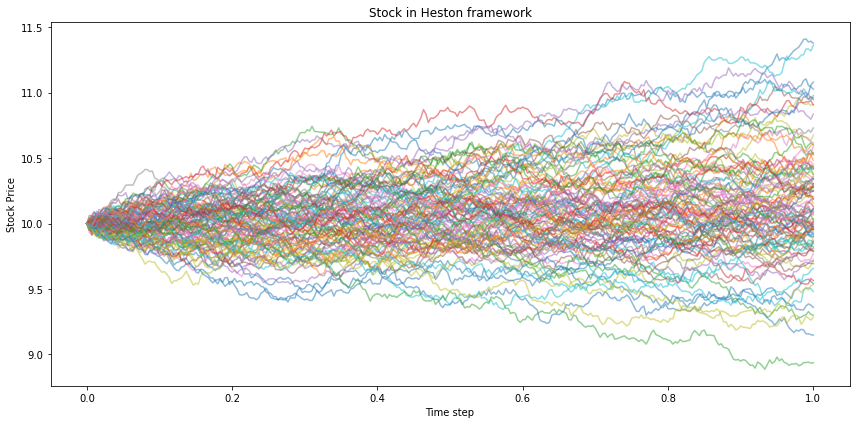

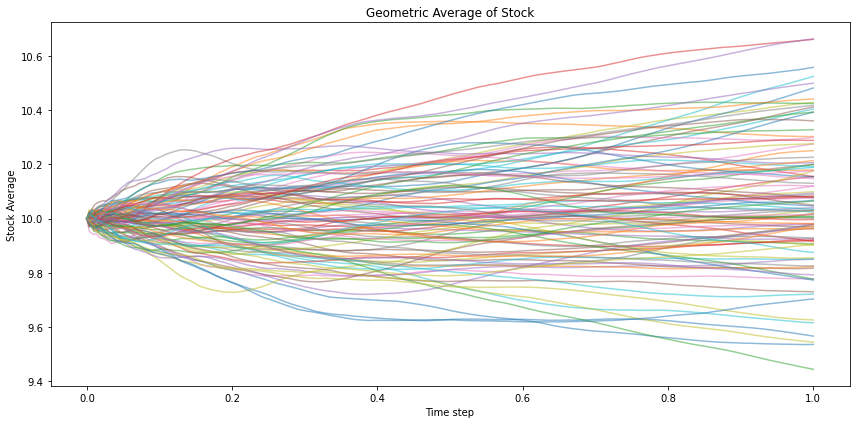

In [5]:
BlackScholesProcess(vol, r, S0, steps, paths, maturity, div).Plot_Diffusion()

## Heston Model Definition

The Heston model is a stochastic volatility model commonly used in quantitative finance to describe the dynamics of asset prices, especially for options pricing. It addresses the shortcomings of the Black-Scholes model by introducing a stochastic process for volatility, which helps explain the observed volatility smile in the options market.

In the Heston model:

1. The underlying asset price $S_t$ follows a geometric Brownian motion, similar to the Black-Scholes model:

$$
dS_t = r S_t dt + \sqrt{v_t} S_t dW_t^{(1)}
$$

where $r$ is the drift of the asset, $v_t$ is the instantaneous variance (volatility squared), $W_t^{(1)}$ is a Wiener process (Brownian motion), and $dW_t^{(1)}$ is its differential.

2. The volatility $v_t$ follows a mean-reverting process, often modeled using the Cox-Ingersoll-Ross (CIR) process:

$$
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW_t^{(2)}
$$

where $\kappa$ is the mean-reversion speed, $\theta$ is the long-term mean variance, $\sigma$ is the volatility of volatility, $W_t^{(2)}$ is another Wiener process, and $dW_t^{(2)}$ is its differential.

The two Wiener processes $W_t^{(1)}$ and $W_t^{(2)}$ are correlated, with a correlation coefficient $\rho$ between them.

By incorporating this stochastic volatility process, the Heston model can better capture the dynamics of option prices across different strikes and maturities.  

## Discretized Heston Model Equations (Euler-Maruyama)

The Heston model can be discretized using the Euler-Maruyama method to approximate the continuous-time stochastic differential equations. Consider a time step $dt$ and discrete time points $t_n = n \cdot dt$. The following equations provide a way to iteratively simulate the asset price $S_{t_n}$ and volatility $v_{t_n}$:

1. For the asset price $S_t$:

$$
S_{t_{n+1}} = S_{t_n} \cdot \exp \left( \left( \mu - \frac{1}{2} v_{t_n} \right) dt + \sqrt{v_{t_n}} \sqrt{dt} Z_1 \right)
$$

2. For the volatility $v_t$:

$$
v_{t_{n+1}} = v_{t_n} + \kappa (\theta - v_{t_n}) dt + \sigma \sqrt{v_{t_n}} \sqrt{dt} Z_2
$$

ere, $Z_1$ and $Z_2$ are correlated random variables sampled from a bivariate normal distribution with correlation $\rho$ at each time step $t_n$.

In [7]:
class HestonProcess:
    
    def __init__(self, rho, volvol, theta, kappa, r, S0, V0, steps, paths, maturity):
        
        self.rho        = rho
        self.volvol     = volvol
        self.theta      = theta
        self.kappa      = kappa 
        self.r          = r 
        self.S0         = S0
        self.V0         = V0
        self.steps      = steps
        self.paths      = paths
        self.T          = maturity
    
    def generate_paths(self):
        
        dt  = self.T/self.steps
        mu  = np.array([0,0])
        cov = np.array([[1,self.rho],
                        [self.rho,1]])
        
        W = ss.multivariate_normal.rvs(mean=mu, cov=cov, size=(self.paths, self.steps))  
        W_S = W[:, :, 0]  
        W_V = W[:, :, 1]  
        S = np.zeros((self.paths, self.steps+1))
        S[:, 0] = S0
        V = np.zeros((self.paths, self.steps+1))
        V[:, 0] = V0
        
        for i in range(0, self.steps):
            S[:,i+1] = S[:,i] * np.exp( (self.r - 0.5*V[:,i])*dt + np.sqrt(V[:,i] * dt) * W_S[:,i] )
            V[:,i+1] = np.maximum(V[:,i] + self.kappa*(self.theta-V[:,i])*dt + self.volvol*np.sqrt(V[:,i]*dt)*W_V[:,i],0)
        
        return S, V
        
    def Plot_Diffusion(self):
        t  = np.linspace(0, self.T, self.steps+1)
        S, V = self.generate_paths()
        plot_diffusion(t, S, "Stock in Heston framework", "Stock Price")
        plot_diffusion(t, V, "Stochastic Volatility in Heston framework", "Volatility")



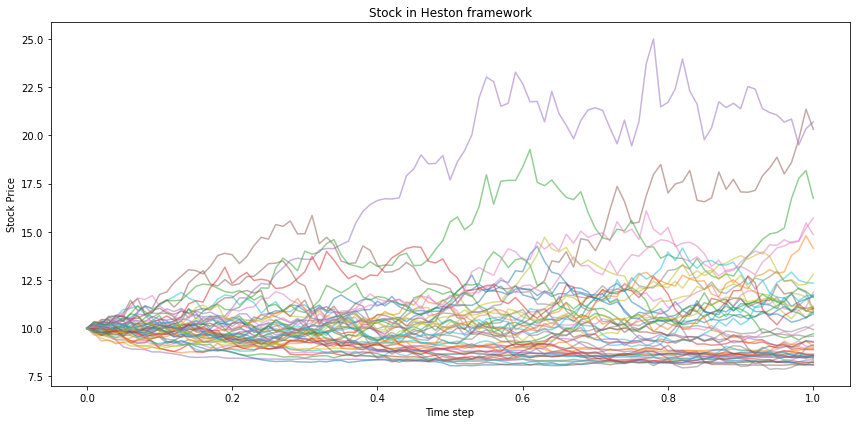

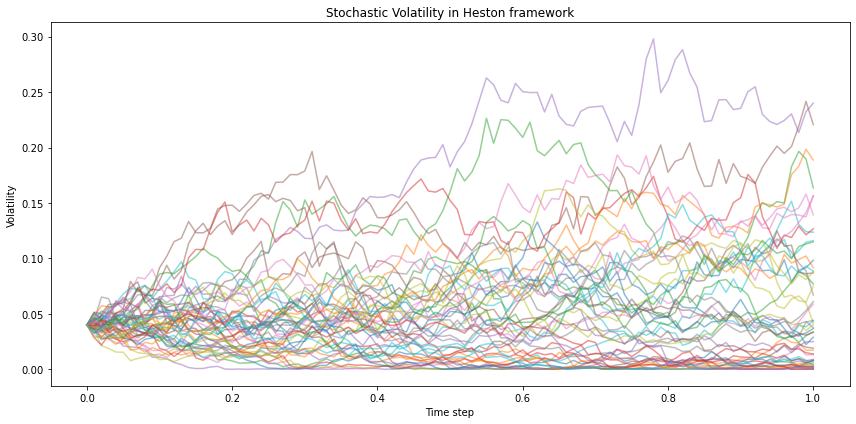

In [8]:
rho, volvol, theta, kappa, r, S0, V0, steps, paths, maturity = 0.9, 0.3, 0.4, 0.05, 0.03, 10, 0.04, 100, 50,1
C = HestonProcess(rho, volvol, theta, kappa, r, S0, V0, steps, paths, maturity)
C.Plot_Diffusion()

## Black-Scholes Formula for European Call Option 

The Black-Scholes formula is used to calculate the theoretical price of a European-style call option at time $t$ between zero and maturity $T$, in the framework of the Black-Scholes model. The formula is given by:

$$
C(S_t, K, r, t, \sigma) = S_t \cdot N(d_1) - K \cdot e^{-r(T-t)} \cdot N(d_2)
$$

Where:

- $N$ is the cumulative standard normal distribution function.
- $d_1$ is calculated as:

$$
d_1 = \frac{{\ln\left(\frac{S_t}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T - t)}}{{\sigma \sqrt{T - t}}}
$$

- $d_2$ is calculated as:

$$
d_2 = d_1 - \sigma \sqrt{T - t}
$$

The formula estimates the value of a call option at time \( t \) based on the difference between the expected future stock price ($S_t \cdot N(d_1)$) and the present value of the strike price ($K \cdot e^{-r(T-t)} \cdot N(d_2)$). The underlying assumption is that the option holder will exercise the option if the expected payoff is greater than the strike price.

Please note that the Black-Scholes model assumes certain idealized conditions and may not fully capture real-world complexities. Extensions and modifications to the model have been proposed to address these limitations and provide more accurate pricing in various market scenarios.


In [6]:
class Call_Vanilla_BS :
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend):
        
        self.vol    = vol
        self.r      = r 
        self.S0     = S0
        self.steps  = steps
        self.paths  = paths
        self.T      = maturity
        self.K      = strike
        self.div    = dividend 
        self.BlackScholes = BlackScholesProcess(self.vol, self.r, self.S0, self.steps, self.paths, self.T, self.div)
        
    
    def get_price(self, t, S):

        d1 = (np.log(S/self.K) + (self.r + self.vol**2 / 2) * (self.T-t)) / (self.vol * np.sqrt(self.T-t))
        d2 = d1 - self.vol*np.sqrt(self.T-t)
        return S*ss.norm.cdf(d1) - self.K * np.exp(-self.r * (self.T-t)) * ss.norm.cdf(d2) 
    
    def Price_Projection(self):
        
        t   = np.linspace(0, self.T, self.steps+1)
        S   = self.BlackScholes.generate_paths()
        MtM = np.zeros_like(S)
        
        for i in range(0, MtM.shape[0]):
            for j in range(0, self.steps):
                MtM[i,j] = self.get_price(t[j], S[i,j])
                
        MtM[:,-1] = np.maximum(0, S[:,-1]-self.K)
        EE = np.mean(np.maximum(0, MtM), axis = 0)
        return MtM, EE
    
        
    def Plot_Results(self):
        t  = np.linspace(0, self.T, self.steps+1)
        MtM, EE = self.Price_Projection()
        plot_results(t, MtM, EE , "Mark to Futur of European Call", "Expected Exposure Profil")



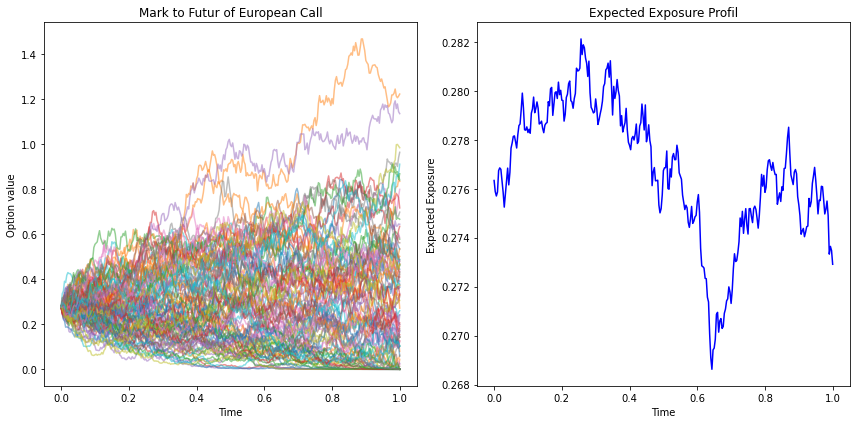

In [7]:
C0 = Call_Vanilla_BS(vol, r, S0, steps, paths, maturity, strike, div)
C0.Plot_Results()

### Pricing vanilla call using heston model : Projection of expected Mark to Market 

In [80]:
class Call_Vanilla_Heston:
    
    def __init__(self, rho, volvol, theta, kappa, r, S0, V0, steps, paths, maturity, strike):
        
        self.rho     = rho
        self.volvol  = volvol
        self.theta   = theta
        self.kappa   = kappa 
        self.r       = r 
        self.S0      = S0
        self.V0      = V0
        self.steps   = steps
        self.paths   = paths
        self.T       = maturity 
        self.K       = strike
        self.Heston = HestonProcess(self.rho, self.volvol, self.theta, self.kappa, self.r, self.S0, self.V0, self.steps, self.paths, self.T)
        
   
    @staticmethod
    def fHeston(s, St, K, r, t, T, sigma, kappa, theta, volvol, rho):
        prod = rho * sigma * i * s

        d1 = (prod - kappa)**2
        d2 = (sigma**2) * (i * s + s**2)
        d = np.sqrt(d1 + d2)

        g1 = kappa - prod - d
        g2 = kappa - prod + d
        g = g1 / g2

        exp1 = np.exp(np.log(St) * i * s) * np.exp(i * s * r * (T-t))
        exp2 = 1 - g * np.exp(-d * (T-t))
        exp3 = 1 - g
        mainExp1 = exp1 * np.power(exp2 / exp3, -2 * theta * kappa / (sigma**2))

        exp4 = (theta * kappa * (T-t)) / (sigma**2)
        exp5 = volvol / (sigma**2)
        exp6 = (1 - np.exp(-d * (T-t))) / (1 - g * np.exp(-d * (T-t)))
        mainExp2 = np.exp((exp4 * g1) + (exp5 * g1 * exp6))

        return (mainExp1 * mainExp2)
    
    
    def get_price(self, t, S):
        
        P, iterations, maxNumber = 0, 1000, 100
        ds = maxNumber / iterations

        element1 = 0.5 * (S - self.K * np.exp(-self.r * (self.T-t)))

        for j in range(1, iterations):
            s1 = ds * (2 * j + 1) / 2
            s2 = s1 - i

            numerator1 = self.fHeston(s2, S, self.K, self.r, t, self.T, self.V0, self.kappa, self.theta, self.volvol, self.rho)
            numerator2 = self.K * self.fHeston(s1, S, self.K, self.r, t, self.T, self.V0, self.kappa, self.theta, self.volvol, self.rho)
            denominator = np.exp(np.log(self.K) * i * s1) * i * s1

            P += ds * (numerator1 - numerator2) / denominator

        element2 = P / np.pi

        return np.real((element1 + element2))
    
    def Price_Projection(self):
                
        t  = np.linspace(0, self.T, self.steps+1)
        S  = self.Heston.generate_paths()[0]
        MtM = np.zeros((self.paths, self.steps+1))
        
        for i in range(0, self.paths):
            for j in range(0, self.steps):
                MtM[i,j] = self.get_price(t[j], S[i,j])
                
        MtM[:,-1] = np.array([np.maximum(0, S[:,-1]-self.K)])
        EE = np.mean(np.maximum(0, MtM), axis = 0) 
        return MtM, EE
    
    def Plot_Results(self):
        
        MtM, EE = self.Price_Projection()
        plot_results(MtM, EE , "Mark to Futur of European Call", "Expected Exposure Profil", y_label="Option Value")


In [85]:
rho, volvol, theta, kappa, r, S0, V0, steps, paths, maturity, strike = 0.9, 0.3, 0.4, 0.05, 0.03, 10, 0.04, 100, 50,1, 10
CH = Call_Vanilla_Heston(rho, volvol, theta, kappa, r, S0, V0, steps, paths, maturity, strike)
   

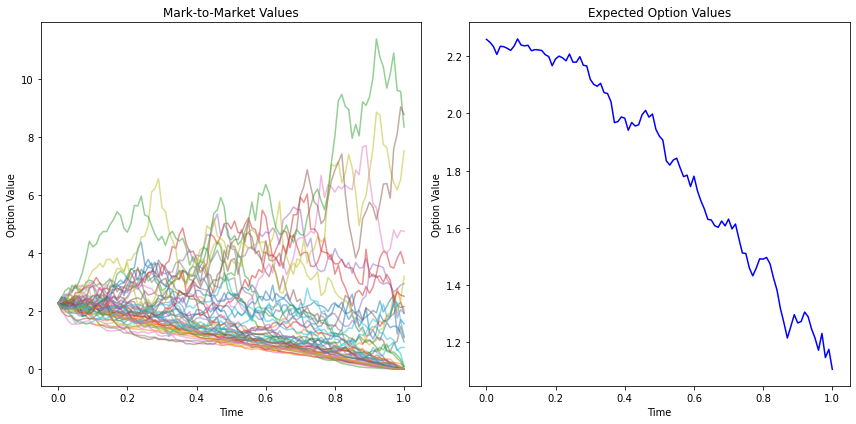

In [87]:
CH.plot_results()

##  Pricing of an Asian call option with a geometric average and a fixed strike  

The payoff of an Asian call option with a geometric average $G$ and a fixed strike $K$ is:  
  
  $$\text{Payoff} = \max(G_T - K, 0)$$

The price of this option at any given time $t$ is given by the formula :

$$
C(S_t, K, r, T, \sigma, t, G_t) = e^{-r(T-t)} \left( G_t^{t/T} S_t^{(T-t)/T} e^{\bar{\mu}+\frac{\bar{\sigma}^2}{2} } \Phi(d_1) - K \Phi(d_2) \right)
$$

Where:
\begin{align*}
\bar{\mu} &= \left(r - q - \frac{\sigma^2}{2}\right)\frac{(T - t)^2}{2T} \\
\bar{\sigma} &= \sqrt{\frac{(T - t)^3}{3}} \cdot \frac{\sigma}{T}\\
d_2 &= \frac{\frac{t}{T} \cdot \ln(G_t) + \frac{T-t}{T} \cdot \ln(S_t) + \bar{\mu}  - \ln(K)}{\bar{\sigma}} \\
d_1 &= d_2 + \bar{\sigma}
\end{align*}


- $S_t$ : stock price at $t$
- $K$ : Strike price
- $r$ : Risk-free rate
- $T$ : Time to maturity
- $\sigma$ : Volatility
- $t$ : Current time 
- $G_t$ : Geometric average of stock prices at $t$


In [9]:
class Call_AsianFixed_BS:
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend):
        
        self.vol    = vol
        self.r      = r 
        self.S0     = S0
        self.steps  = steps
        self.paths  = paths
        self.T      = maturity
        self.K      = strike
        self.div    = dividend 
        self.BlackScholes = BlackScholesProcess(self.vol, self.r, self.S0, self.steps, self.paths, self.T, self.div)

    
    def get_price(self, t, S, G):
        
        mu  = (self.r-self.div -0.5*self.vol**2)*(self.T - t)**2/(2*self.T)
        sig = np.sqrt((self.T-t)**3/3)*self.vol/self.T
        d2 = (t*np.log(G)/self.T + (self.T-t)*np.log(S)/self.T + mu - np.log(self.K))/sig
        d1 = d2 + sig
                
        return np.exp(-self.r * (self.T-t))*(G**(t/self.T)*S**((self.T-t)/self.T)*np.exp(mu+0.5*sig**2)*ss.norm.cdf(d1) - self.K*ss.norm.cdf(d2))
    
    def Price_Projection(self):
        
        t    = np.linspace(0, self.T, self.steps+1)
        S, G = self.BlackScholes.generate_geometric()
        MtM  = np.zeros_like(S)
        
        for i in range(0, MtM.shape[0]):
            for j in range(0, self.steps):
                MtM[i,j] = self.get_price(t[j], S[i,j], G[i,j])
        
        MtM[:,-1] = np.maximum(0, G[:,-1]-self.K)  
        EE = np.mean(np.maximum(0, MtM), axis = 0)
        return MtM, EE

    def Plot_Results(self):
        
        t = np.linspace(0, self.T, self.steps+1)
        MtM, EE = self.Price_Projection()
        plot_results(t, MtM, EE , "Mark to Futur of Asian Call with Fixed Strike", "Expected Exposure Profil of Asian Call with Fixed Strike")



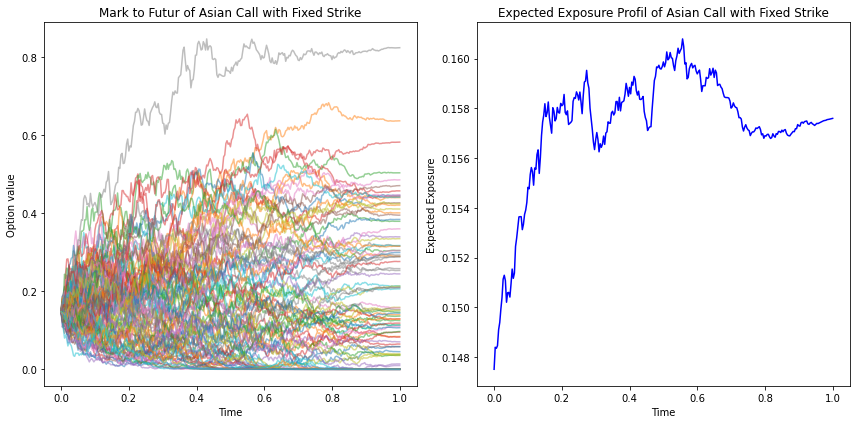

In [10]:
C1 = Call_AsianFixed_BS(vol, r, S0, steps, paths, maturity, strike, div)
C1.Plot_Results()

### Pricing Formula for Asian Call Option with Geometric Average and Floating Strike

The payoff of an Asian call option with a geometric average and a floating strike is :  
  
  $$\text{Payoff} = \max(S_T - G_T, 0)$$

The price of this option at abu given time $t$ is given by the formula :
$$
C(S_t, G_t, r, T, \sigma, t) = e^{-q \cdot (T-t)} \left( S_t \cdot \Phi(d_1) - G_t^{\frac{t}{T}} \cdot S_t^{\frac{T-t}{T}} \cdot e^{-Q} \cdot \Phi(d_2) \right)
$$

Where:
\begin{align*}
d_1 &= \frac{t \cdot \ln\left(\frac{S_t}{G_t}\right) + \left(r-q+\frac{\sigma^2}{2}\right) \cdot \frac{(T^2-t^2)}{2}}{\sigma \cdot \sqrt{\frac{T^3-t^3}{3}}} \\
d_2 &= d_1 - \frac{\sigma \cdot \sqrt{\frac{T^3-t^3}{3}}}{T} \\
Q &= \frac{1}{2T} \left(r-q+\frac{\sigma^2}{2}\right) \cdot (T^2-t^2) - \frac{\sigma^2}{6T^2} \cdot (T^3-t^3)
\end{align*}

Here, $C(S_t, G_t, r, T, \sigma, t)$ represents the price of the Asian call option  at time $t$ with the following parameters:

- $S_t$ : Stock price at time $t$
- $G_t$ : Geometric average of stock prices at time $t$
- $r$   : Risk-free rate
- $q$   : Dividend yield
- $T$   : Time to maturity
- $\sigma$ : Volatility




In [11]:
class Call_AsianFloat_BS:
    
    def __init__(self, vol, r, S0, steps, paths, maturity, dividend):
        
        self.vol    = vol
        self.r      = r 
        self.S0     = S0
        self.steps  = steps
        self.paths  = paths
        self.T      = maturity
        self.div    = dividend 
        self.BlackScholes = BlackScholesProcess(self.vol, self.r, self.S0, self.steps, self.paths, self.T, self.div)
        
    def get_price(self, t, S, G):
        
        Q  = 1/(2*self.T)*(self.r-self.div+self.vol**2/2)*(self.T**2-t**2) - self.vol**2/(6*self.T**2)*(self.T**3-t**3)  
        d1 = (t*np.log(S/G)+(self.r-self.div+self.vol**2/2)*(self.T**2-t**2)*0.5)/(self.vol*np.sqrt((self.T**3-t**3)/3))
        d2 = d1 - self.vol*np.sqrt((self.T**3-t**3)/3)/self.T
        
        return np.exp(-self.div * (self.T-t))*(S*ss.norm.cdf(d1) - G**(t/self.T)*S**((self.T-t)/self.T)*np.exp(-Q)*ss.norm.cdf(d2))
    

    def Price_Projection(self):
        
        t    = np.linspace(0, self.T, self.steps+1)
        S, G = self.BlackScholes.generate_geometric()
        MtM  = np.zeros_like(S)
        
        for i in range(0, MtM.shape[0]):
            for j in range(0, self.steps):
                MtM[i,j] = self.get_price(t[j], S[i,j], G[i,j])
        
        MtM[:,-1] = np.maximum(0, S[:,-1]-G[:,-1])  
        EE = np.mean(np.maximum(0, MtM), axis = 0)
        return MtM, EE
    

    def Plot_Results(self): 
        t = np.linspace(0, self.T, self.steps+1)
        MtM, EE = self.Price_Projection()
        plot_results(t, MtM, EE , "Mark to Futur of Asian Call with Floating Strike", "Expected Exposure Profil of Asian Call with Floating Strike")


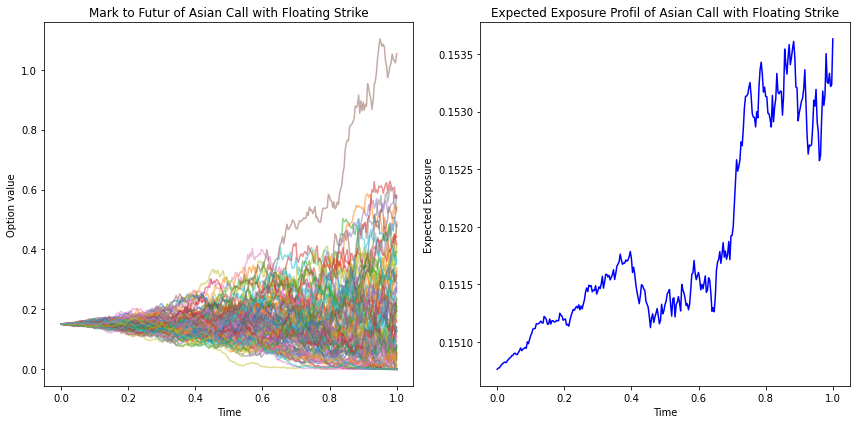

In [117]:
C2 = Call_AsianFloat_BS(vol, r, S0, steps, paths, maturity, div)
C2.Plot_Results()

In [12]:
class LongstaffSchwartz:
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend):
        
        self.vol    = vol
        self.r      = r 
        self.S0     = S0
        self.steps  = steps
        self.paths  = paths
        self.T      = maturity
        self.div    = dividend 
        self.K      = strike
        self.BlackScholes = BlackScholesProcess(self.vol, self.r, self.S0, self.steps, self.paths, self.T, self.div)
        
    def Price_Projection(self):
        
        S = self.BlackScholes.generate_paths()
        IV = np.maximum(self.K - S, 0)          
        MtM = np.zeros_like(IV)             
        MtM[:,-1] = IV[:,-1]
        df = np.exp(-self.r * (self.T/self.steps))
        
        for t in range(self.steps-2, 0, -1):

            right_paths = IV[:,t] > 0        
            rg = np.polyfit( S[right_paths, t], MtM[right_paths, t+1] * df, 2)    
            C = np.polyval( rg, S[right_paths,t] )                              
            exercise = np.zeros( len(right_paths), dtype=bool)    
            exercise[right_paths] = IV[right_paths,t] > C           
            MtM[exercise,t] = IV[exercise,t]                        
            MtM[exercise,t+1:] = 0                                  
            discount_path = (MtM[:,t] == 0)                        
            MtM[discount_path,t] = MtM[discount_path,t+1] * df
        
        MtM[:,0] = MtM[:,1] * df 
        EE = np.mean(np.maximum(0, MtM), axis = 0)
        
        return EE

    def plot_results(self):
        
        plt.figure(figsize=(12, 6))
        t = np.linspace(0, self.T, self.steps+1)
        EE = self.Price_Projection()

        plt.plot(t, EE, color='blue')
        plt.title('Expected Option Values')
        plt.xlabel('Time')
        plt.ylabel('Option Value')
        plt.show()   
   
    

In [44]:
LS = LongstaffSchwartz(vol, r, S0, 365 , 1000, maturity, strike, 0)

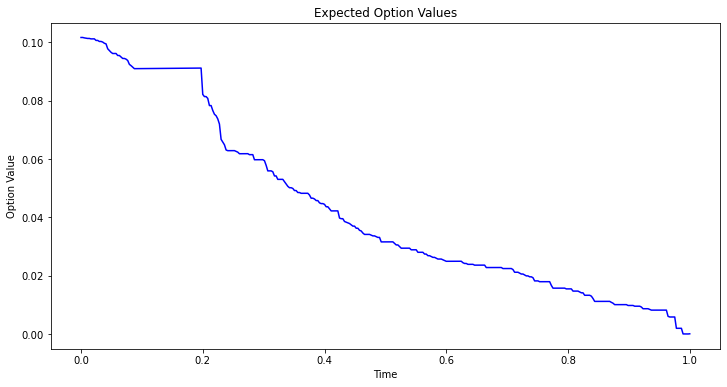

In [45]:
LS.plot_results()

### Variance reduction : Antithetic Variables 

In [13]:
class BlackScholesVarReduction(BlackScholesProcess):
    
    def __init__(self, vol, r, S0, steps, paths, maturity, dividend):
        super().__init__(vol, r, S0, steps, paths, maturity, dividend)
    
    def generate_paths(self):
        
        dt = self.T/self.steps
        W  = np.random.randn(self.paths,self.steps)
        S  = self.S0*np.cumprod(np.exp((self.r - self.vol**2/2)*dt + self.vol*np.sqrt(dt)*W), axis = 1)
        S  = np.concatenate((S, S0*np.cumprod(np.exp((self.r - self.vol**2/2)*dt + self.vol*np.sqrt(dt)*(-W)), axis = 0)))       
        return np.concatenate((np.array([self.S0*np.ones(2*self.paths)]).T, S), axis = 1)   

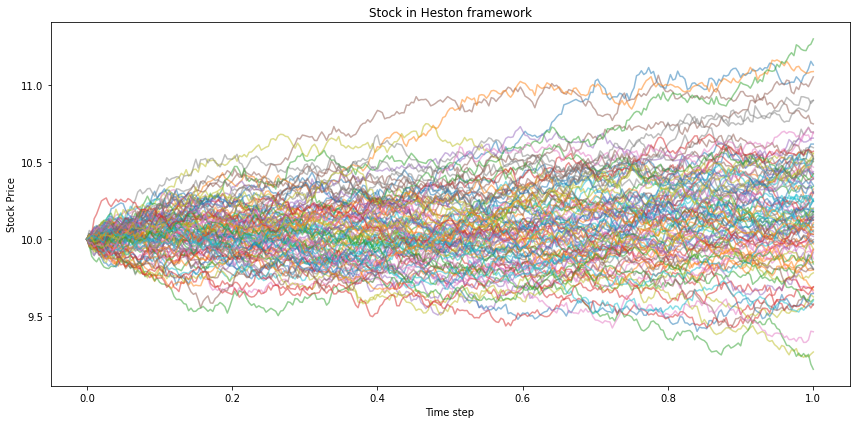

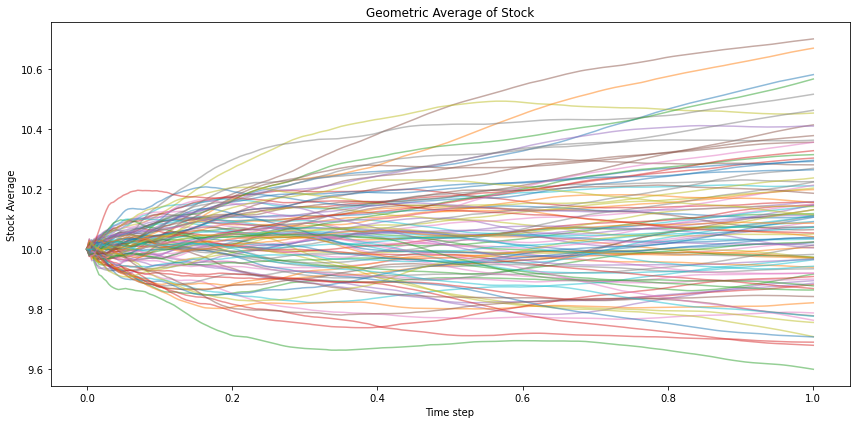

In [14]:
BlackScholesVarReduction(vol, r, S0, steps, paths, maturity, div).Plot_Diffusion()

In [ ]:
class Call_Vanilla_BS_Antithetic(Call_Vanilla_BS) :
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend):
        super().__init__(vol, r, S0, steps, paths, maturity, strike, dividend)    
        self.BlackScholes = BlackScholesVarReduction(vol, r, S0, steps, paths, maturity, dividend)

class Call_AsianFixed_BS_Antithetic(Call_AsianFixed_BS) :
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend):
        super().__init__(vol, r, S0, steps, paths, maturity, strike, dividend)    
        self.BlackScholes = BlackScholesVarReduction(vol, r, S0, steps, paths, maturity, dividend)

class Call_AsianFloat_BS_Antithetic(Call_AsianFloat_BS) :
    
    def __init__(self, vol, r, S0, steps, paths, maturity, dividend):
        super().__init__(vol, r, S0, steps, paths, maturity, dividend)    
        self.BlackScholes = BlackScholesVarReduction(vol, r, S0, steps, paths, maturity, dividend)

class LongstaffSchwartz_Antithetic(LongstaffSchwartz) :
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend):
        super().__init__(vol, r, S0, steps, paths, maturity, strike, dividend)    
        self.BlackScholes = BlackScholesVarReduction(vol, r, S0, steps, paths, maturity, dividend)

In [ ]:
Call_Vanilla_BS_Antithetic(vol, r, S0, steps, paths, maturity, strike, div).Plot_Results()

In [ ]:
Call_AsianFixed_BS_Antithetic(vol, r, S0, steps, paths, maturity, strike, div).Plot_Results()

In [ ]:
Call_AsianFloat_BS_Antithetic(vol, r, S0, steps, paths, maturity, strike, div).Plot_Results()

In [ ]:
LongstaffSchwartz_Antithetic(vol, r, S0, steps, paths, maturity, strike, div).Plot_Results()

In [18]:
class CVA_Base:
    
    def __init__(self, vol, r, S0, steps, paths, maturity, LGD, call_class, call_args):
        
        self.vol    = vol
        self.r      = r 
        self.S0     = S0
        self.steps  = steps
        self.paths  = paths
        self.T      = maturity
        self.LGD    = LGD
        self.call   = call_class(*call_args)       
        self.div    = None  
 
    
    def SurvivalProb(self):
        
        a, b = 4.06, 52
        t, dt  = np.linspace(0, self.T, self.steps+1), self.T/self.steps
        spread = [a*step*dt + b for step in range(0, self.steps+1)] 
        
        return [np.exp(-spread[step]*t[step]/(self.LGD*10000)) for step in range(0, self.steps+1)]
    
    def Compute_CVA(self):
        
        t  = np.linspace(0, self.T, self.steps+1)
        DF = np.exp(-self.r*t)
        EE = self.call.Price_Projection()
        PS = self.SurvivalProb() 
       
        return self.LGD*sum([np.max(PS[step]-PS[step+1], 0)*EE[step+1]*DF[step+1] for step in range(0, self.steps)])
    
class CVA_VanillaCall(CVA_Base):
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend, LGD):
        call_args = (vol, r, S0, steps, paths, maturity, strike, dividend)
        super().__init__(vol, r, S0, steps, paths, maturity, LGD, Call_Vanilla_BS, call_args)

class CVA_AsianCallFloat(CVA_Base):
    
    def __init__(self, vol, r, S0, steps, paths, maturity, dividend, LGD):
        call_args = (vol, r, S0, steps, paths, maturity, dividend)
        super().__init__(vol, r, S0, steps, paths, maturity, LGD, Call_AsianFloat_BS, call_args)
        
class CVA_AsianCallFixed(CVA_Base):
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend, LGD):
        call_args = (vol, r, S0, steps, paths, maturity, strike, dividend)
        super().__init__(vol, r, S0, steps, paths, maturity, LGD, Call_AsianFixed_BS, call_args)
        
class CVA_AmericanPut(CVA_Base):
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend, LGD):
        call_args = (vol, r, S0, steps, paths, maturity, strike, dividend)
        super().__init__(vol, r, S0, steps, paths, maturity, LGD, LongstaffSchwartz, call_args)

    
        


### Adding the option reduction to the privious classes

In [ ]:
class CVA_VanillaCall(CVA_Base):
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend, LGD, reduction):
        call_args = (vol, r, S0, steps, paths, maturity, strike, dividend)
        
        if reduction == True:
            Class = Call_Vanilla_BS_Antithetic
        else:
            Class = Call_Vanilla_BS
            
        super().__init__(vol, r, S0, steps, paths, maturity, LGD, Class, call_args)

class CVA_AsianCallFloat(CVA_Base):
    
    def __init__(self, vol, r, S0, steps, paths, maturity, dividend, LGD):
        call_args = (vol, r, S0, steps, paths, maturity, dividend)
        
        if reduction == True:
            Class = Call_AsianFloat_BS_Antithetic
        else:
            Class = Call_AsianFloat_BS
            
        super().__init__(vol, r, S0, steps, paths, maturity, LGD, Class, call_args)
        
class CVA_AsianCallFixed(CVA_Base):
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend, LGD):
        call_args = (vol, r, S0, steps, paths, maturity, strike, dividend)
        
        if reduction == True:
            Class = Call_AsianFixed_BS_Antithetic
        else:
            Class = Call_AsianFixed_BS
            
        super().__init__(vol, r, S0, steps, paths, maturity, LGD, Class, call_args)
        
class CVA_AmericanPut(CVA_Base):
    
    def __init__(self, vol, r, S0, steps, paths, maturity, strike, dividend, LGD):
        call_args = (vol, r, S0, steps, paths, maturity, strike, dividend)
        
        if reduction == True:
            Class = LongstaffSchwartz_Antithetic
        else:
            Class = LongstaffSchwartz
        super().__init__(vol, r, S0, steps, paths, maturity, LGD, Class, call_args)